In [87]:
import pandas as pd

csv_df = pd.read_csv('CornPoints2022-ottawa-montreal.csv')
csv_df.head()

,system:index,landcover,longitude,latitude
0,1,1,-73.094563,45.934212
1,8,1,-75.275531,45.120618
2,9,1,-74.918176,45.421723
3,14,1,-73.061050,45.305319
4,18,1,-73.240261,45.080768


In [88]:
import requests

i = 0
data = []
for entry in csv_df.itertuples():
    i += 1
    if i > 5:
        break

    payload = {
        "latitude": entry.latitude,
        "longitude": entry.longitude,
        "year": 2022
    }
    print("Requesting:", payload)
    r = requests.post("http://127.0.0.1:5000/getData", json=payload, timeout=10)
    r.raise_for_status()
    data.append(r.json())

with open('data.json', 'w') as f:
    import json
    json.dump(data, f, indent=2)

Requesting: {'latitude': 45.93421222247435, 'longitude': -73.09456288134471, 'year': 2022}
Requesting: {'latitude': 45.120618020444816, 'longitude': -75.2755305805278, 'year': 2022}
Requesting: {'latitude': 45.421723169005574, 'longitude': -74.91817602457512, 'year': 2022}
Requesting: {'latitude': 45.305319464463125, 'longitude': -73.06104994476225, 'year': 2022}
Requesting: {'latitude': 45.08076830151817, 'longitude': -73.24026134794147, 'year': 2022}


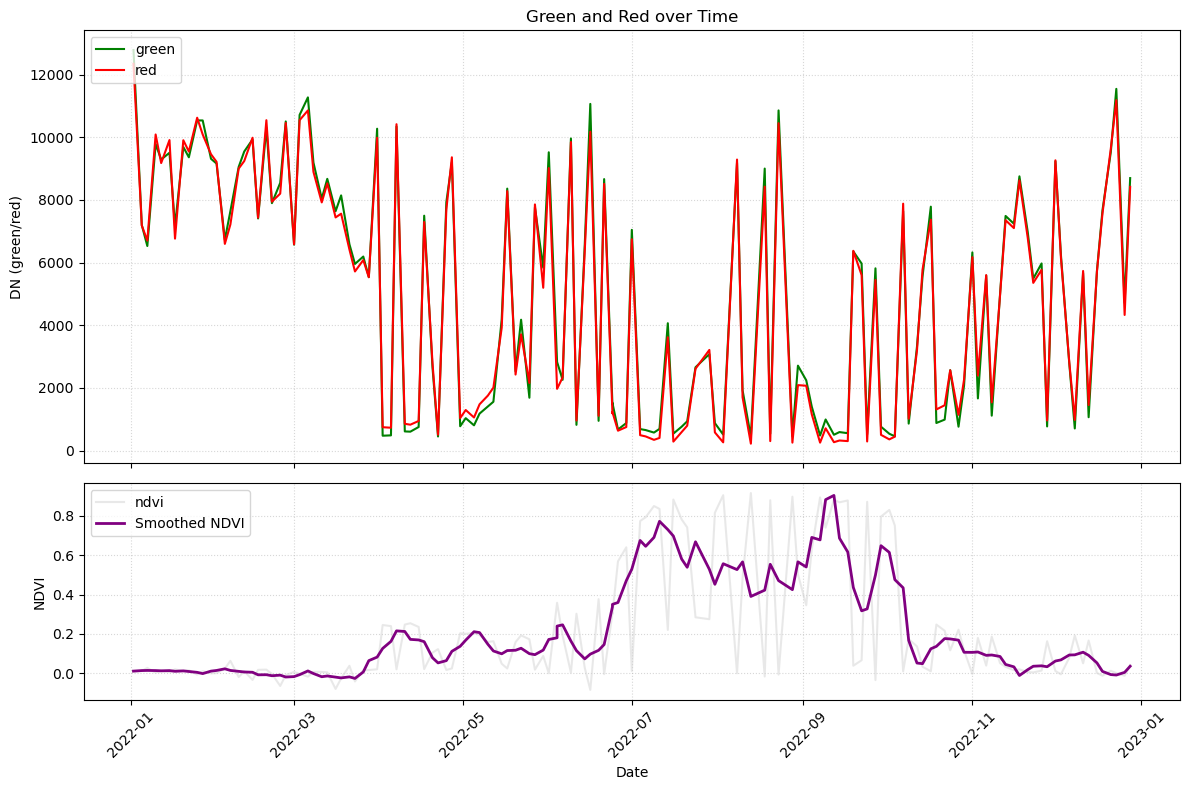

            green    red      ndvi  ndvi_smooth  ndvi_norm
date                                                      
2022-01-02  12784  12344  0.009628     0.011093   0.040038
2022-01-05   7196   7184  0.012101     0.013819   0.042968
2022-01-07   6528   6700  0.027294     0.014478   0.043676
2022-01-10   9783  10088  0.002768     0.013803   0.042951
2022-01-12   9288   9176  0.012909     0.012528   0.041580


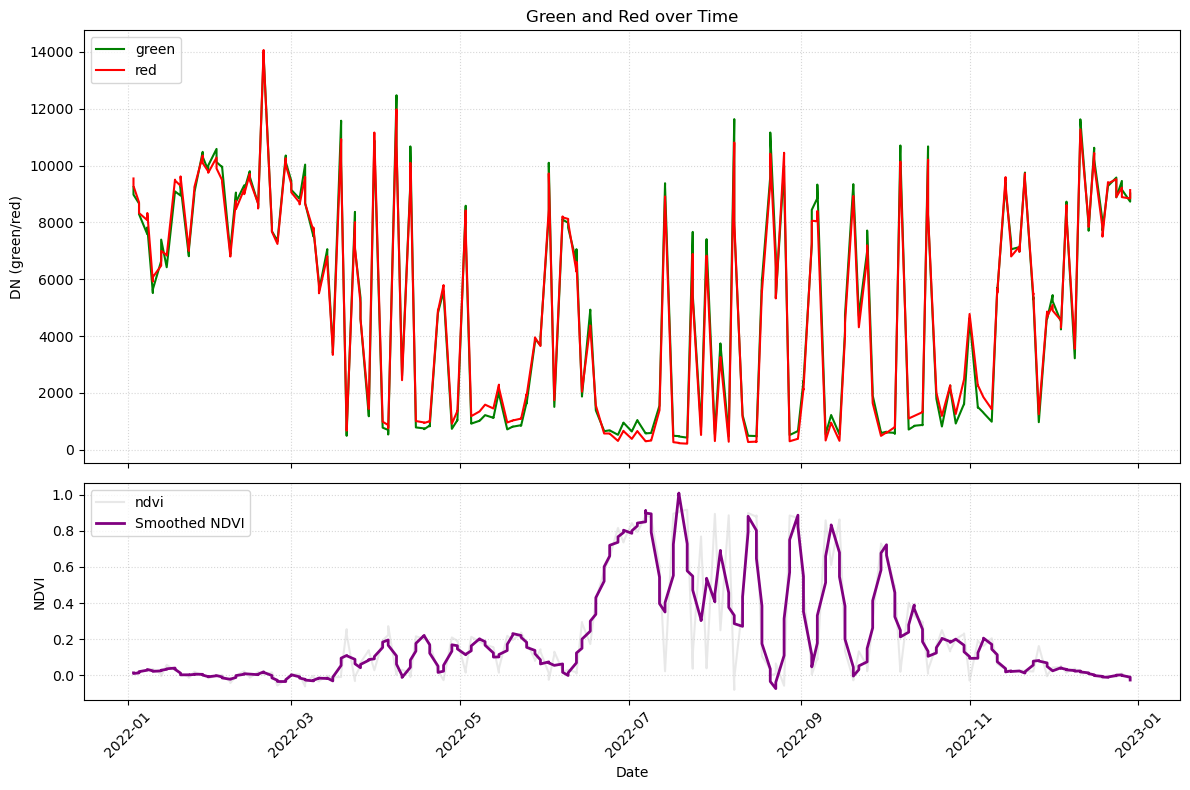

            green   red      ndvi  ndvi_smooth  ndvi_norm
date                                                     
2022-01-03   9242  9544  0.011906     0.013795   0.080444
2022-01-03   8974  9279  0.013187     0.010332   0.077244
2022-01-05   8664  8704  0.015385     0.013577   0.080243
2022-01-05   8288  8328  0.016997     0.020627   0.086757
2022-01-08   7580  8076  0.031016     0.028577   0.094104


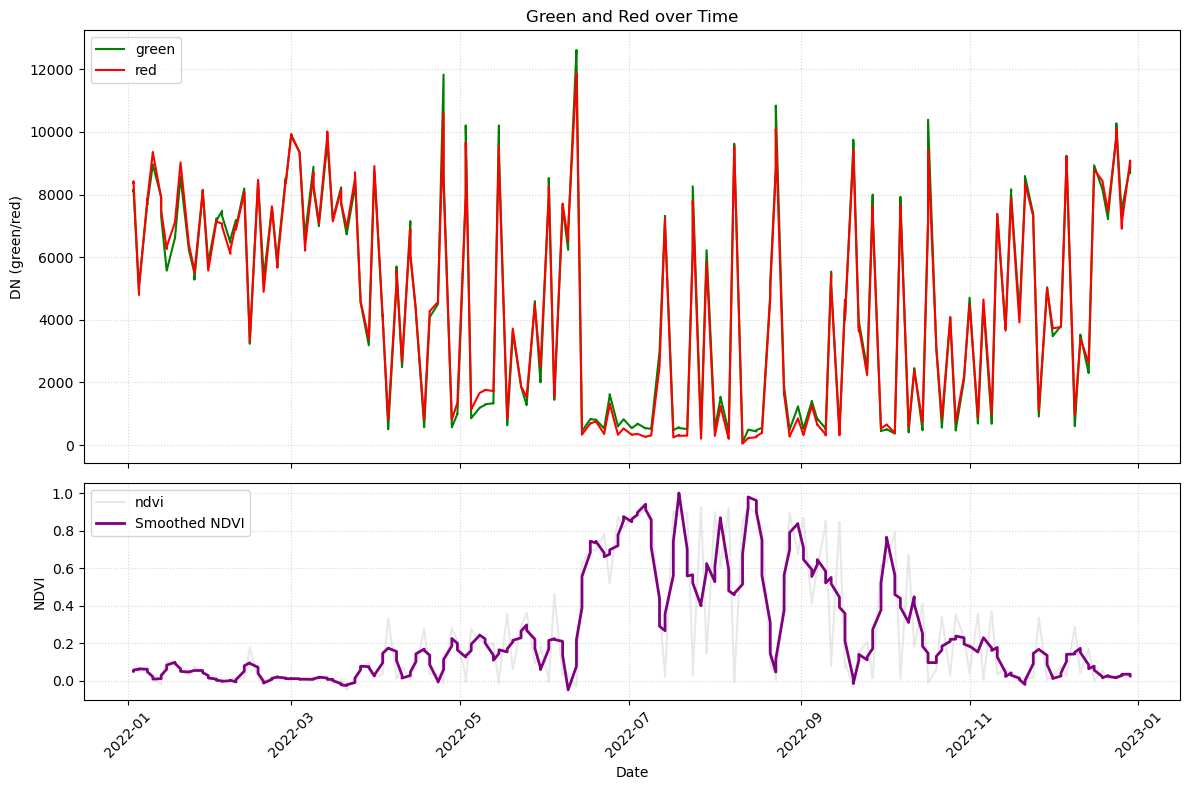

            green   red      ndvi  ndvi_smooth  ndvi_norm
date                                                     
2022-01-03   8111  8374  0.054266     0.050200   0.094656
2022-01-03   8168  8424  0.054333     0.056681   0.100825
2022-01-05   4904  4796  0.052548     0.061434   0.105350
2022-01-05   5124  5020  0.059925     0.063107   0.106942
2022-01-08   7714  7856  0.071395     0.060347   0.104315


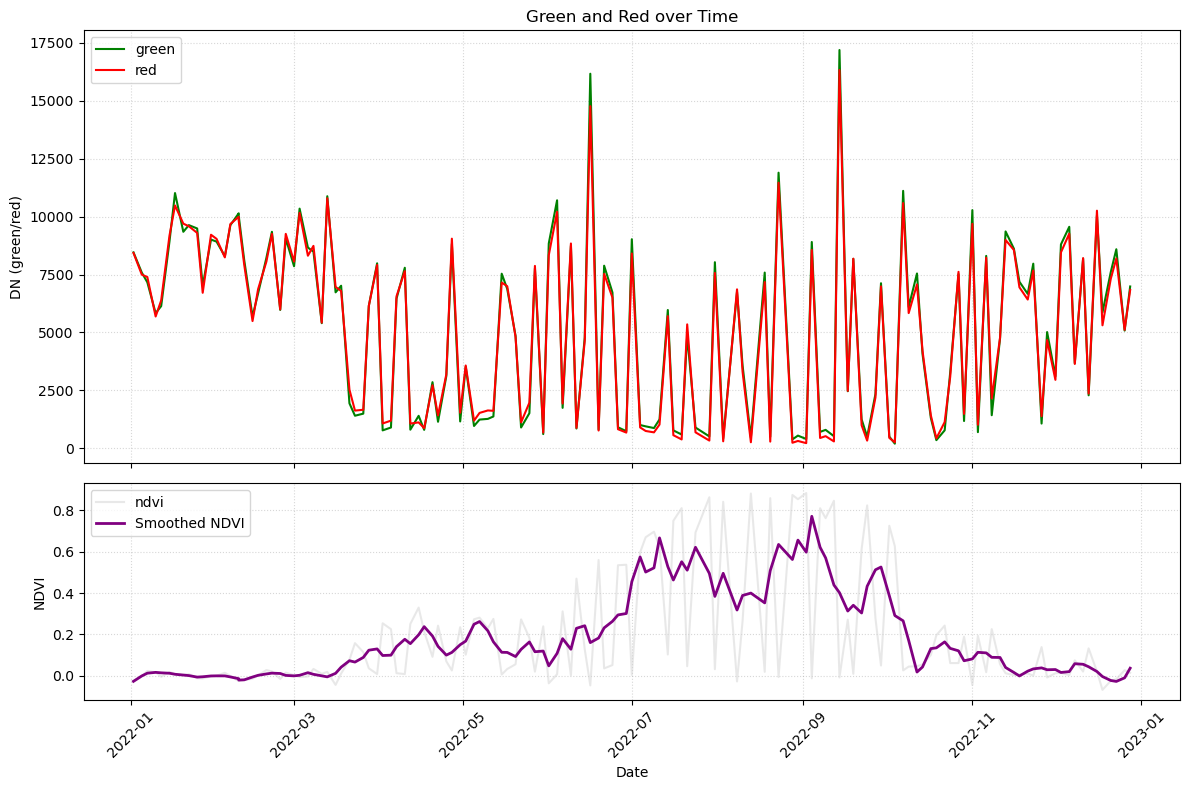

            green   red      ndvi  ndvi_smooth  ndvi_norm
date                                                     
2022-01-02   8456  8432 -0.028042    -0.026559   0.000732
2022-01-05   7584  7496 -0.002675    -0.000603   0.033253
2022-01-07   7164  7392  0.023514     0.012699   0.049921
2022-01-10   5832  5688  0.017277     0.016621   0.054835
2022-01-12   6136  6380 -0.004724     0.014433   0.052094


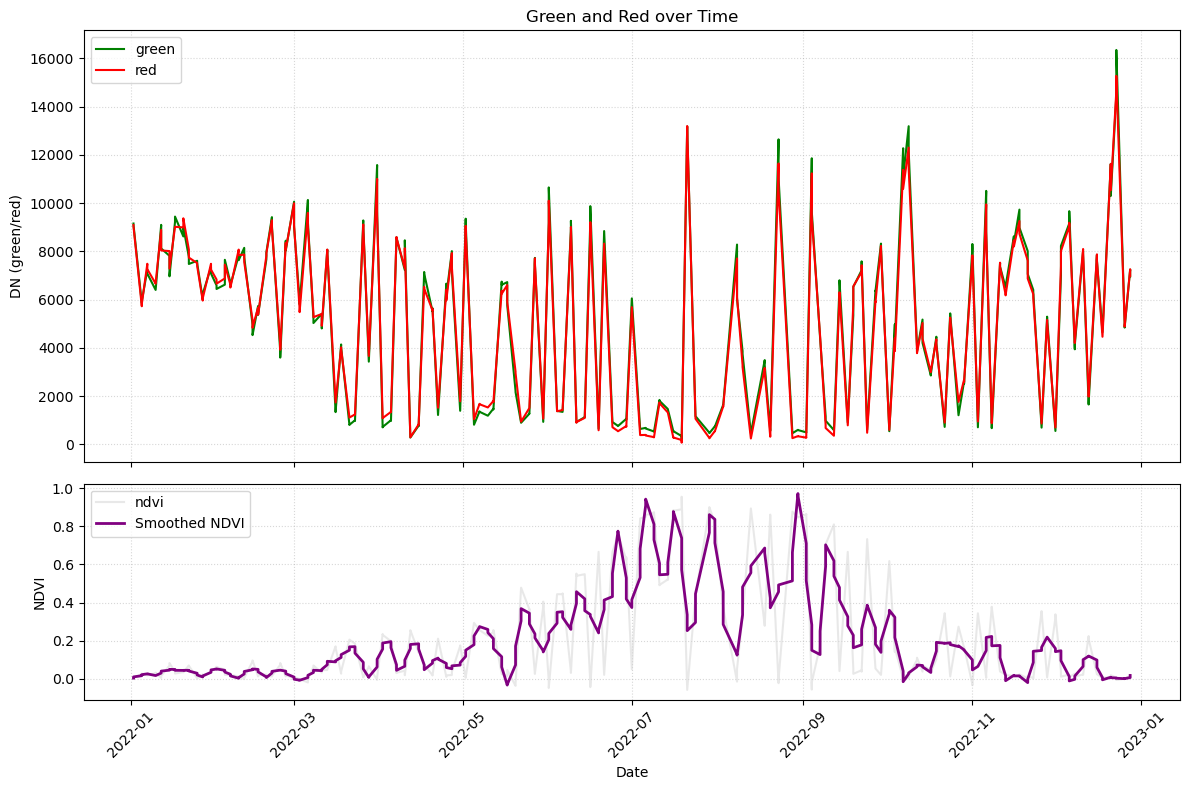

            green   red      ndvi  ndvi_smooth  ndvi_norm
date                                                     
2022-01-02   9152  9088  0.003946     0.003639   0.036397
2022-01-02   9104  9032  0.003970     0.009967   0.042692
2022-01-05   5856  5724  0.025204     0.016341   0.049033
2022-01-05   5932  5816  0.027425     0.021959   0.054621
2022-01-07   7240  7484  0.018621     0.026017   0.058658


In [89]:
# Load data.json and plot green+red on top, ndvi on bottom (shared x-axis)
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Read the JSON file
with open('data.json', 'r') as f:
    datas = json.load(f)

for data in datas:
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    # df['ndvi_smooth'] = df['ndvi'].rolling(window=20, center=True, min_periods=1).mean()
    from scipy.signal import savgol_filter
    df['ndvi_smooth'] = savgol_filter(df['ndvi'], window_length=9, polyorder=3)

    ndvi_min = df['ndvi_smooth'].min()
    ndvi_max = df['ndvi_smooth'].max()
    df['ndvi_norm'] = (df['ndvi_smooth'] - ndvi_min) / (ndvi_max - ndvi_min)

    # Set date index
    df.set_index('date', inplace=True)

    # Create two stacked subplots that share the x-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12,8), sharex=True,
                                            gridspec_kw={'height_ratios':[2,1]})

    # Top plot: green and red
    ax_top.plot(df.index, df['green'], label='green', color='green')
    ax_top.plot(df.index, df['red'], label='red', color='red')
    ax_top.set_ylabel('DN (green/red)')
    ax_top.legend(loc='upper left')
    ax_top.set_title('Green and Red over Time')
    ax_top.grid(True, linestyle=':', alpha=0.5)

    # Bottom plot: NDVI
    ax_bottom.plot(df.index, df['ndvi'], label='ndvi', color='lightgray', alpha=0.5)
    ax_bottom.plot(df.index, df['ndvi_smooth'], color='purple', linewidth=2, label='Smoothed NDVI')
    ax_bottom.set_ylabel('NDVI')
    ax_bottom.set_xlabel('Date')
    ax_bottom.legend(loc='upper left')
    ax_bottom.grid(True, linestyle=':', alpha=0.5)

    # Improve x-axis date labels
    plt.setp(ax_bottom.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

    # Display head of dataframe
    print(df.head())
